In [12]:
import torch
from torchanalyse  import profiler, System, Unit, dot_roofline, display_df, tracegen

unit = Unit()
hopper_system = System(
    unit,
    flops=990,
    offchip_mem_bw=4000,
)



In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
text = "Replace me by any text you'd like."

encoded_input = tokenizer(text, return_tensors='pt')
tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
encoded_input = tokenizer(text, return_tensors='pt')

In [14]:
from transformers import GemmaModel, GemmaConfig
gemmaconfig = GemmaConfig(num_hidden_layers=1)     ## 7B
gemma_model = GemmaModel(gemmaconfig)



In [15]:
import torch
B = 32
N = 1024
random_text = torch.randint(2, 235248, (B, N))
encoded_input = torch.cat((torch.full((random_text.size(0), 1), 2), random_text, torch.full((random_text.size(0), 1), 235248)), dim=1)

In [16]:
encoded_input.shape

torch.Size([32, 1026])

In [17]:
graph = tracegen(gemma_model, encoded_input)

In [18]:
# This will reload the imported modules (e.g. src.analysis, src.model) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
graph

transformers.models.gemma.modeling_gemma.GemmaModel (
	%input: long[32, 1026],
	%1: float[256000, 3072],
	%2: float[4096, 3072],
	%3: float[4096, 3072],
	%4: float[4096, 3072],
	%5: float[3072, 4096],
	%6: float[24576, 3072],
	%7: float[24576, 3072],
	%8: float[3072, 24576],
	%9: float[3072],
	%10: float[3072],
	%11: float[3072]
):
	%12: int = prim::constant[value = 0]()
	%13: bool = prim::constant[value = 0]()
	%14: bool = prim::constant[value = 0]()
	%inputs_embeds: float[32, 1026, 3072] = aten::embedding(%1: float[256000, 3072], %input: long[32, 1026], %12: int, %13: bool, %14: bool)
	%19: int = prim::constant[value = 1]()
	%20: int = aten::size(%inputs_embeds: float[32, 1026, 3072], %19: int)
	%21: long[] = prim::numtotensor(%20: int)
	%25: long[] = prim::constant[value = tensor(0)]()
	%26: int = prim::constant[value = 1]()
	%27: long[] = aten::add(%21: long[], %25: long[], %26: int)
	%28: number = aten::scalarimplicit(%27: long[])
	%29: int = prim::constant[value = 0]()
	%30: none

In [20]:


# macs = profile_macs(model, inputs)
# print('transformer: {:.4g} G'.format(macs / 1e9))
op_df = profiler(gemma_model, encoded_input, hopper_system, unit, graph=graph)


/Users/abambhaniya3/Work/DL_codes/torchanalyse/torchanalyse/plots.py:69: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_bound_type, subset=['Bound'])\


,Op Type,Operator A,Operator B,Output,Op Intensity,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy
0,aten::mul,"[32, 1, 8192, 8192]",1,"[32, 1, 8192, 8192]",0.500000,4294.967296,2147.483648,0.000001,2147.483648,4294.967297,M,4078.049756,2018634.629590,0.002020,2018634.629590,8.618633,2.000000,2.147484,1.000000
1,aten::mul,"[32, 1026, 3072]",1,"[32, 1026, 3072]",0.500000,201.719808,100.859904,0.000001,100.859904,201.719809,M,191.531939,94808.310230,0.002020,94808.310230,0.404787,2.000000,0.100860,1.000000
2,aten::pow,"[32, 1026, 3072]",0,"[32, 1026, 3072]",0.500000,201.719808,100.859904,0.000000,100.859904,201.719808,M,23702.077440,94808.309760,0.250000,94808.309760,0.404787,2.000000,0.100860,1.000000
3,aten::mean,"[32, 1026, 3072]",0,"[32, 1026, 1]",0.000325,0.065664,100.859904,0.000000,0.032832,100.892736,M,7.715520,47419.585920,0.000163,47419.585920,0.202460,0.001302,0.050446,1.000000
4,aten::rsqrt,"[32, 1026, 1]",0,"[32, 1026, 1]",0.500000,0.065664,0.032832,0.000000,0.032832,0.065664,M,7.715520,30.862080,0.250000,30.862080,0.000132,2.000000,0.000033,1.000000
5,aten::mul,"[32, 1026, 3072]","[32, 1026, 1]","[32, 1026, 3072]",0.499919,201.719808,100.859904,0.032832,100.859904,201.752640,M,191.531939,94823.740800,0.002020,94823.740800,0.404853,1.999675,0.100876,1.000000
6,aten::mul,"[32, 1026, 3072]",[3072],"[32, 1026, 3072]",0.499992,201.719808,100.859904,0.003072,100.859904,201.722880,M,191.531939,94809.753600,0.002020,94809.753600,0.404794,1.999970,0.100861,1.000000
7,aten::linear,"[32, 1026, 3072]","[4096, 3072]","[32, 1026, 4096]",1666.334655,826244.333568,100.859904,12.582912,134.479872,247.922688,C,784514.821772,116523.663360,6.732665,784514.821772,3.349514,990.000000,0.834590,1.000000
8,aten::linear,"[32, 1026, 3072]","[4096, 3072]","[32, 1026, 4096]",1666.334655,826244.333568,100.859904,12.582912,134.479872,247.922688,C,784514.821772,116523.663360,6.732665,784514.821772,3.349514,990.000000,0.834590,1.000000
9,aten::linear,"[32, 1026, 3072]","[4096, 3072]","[32, 1026, 4096]",1666.334655,826244.333568,100.859904,12.582912,134.479872,247.922688,C,784514.821772,116523.663360,6.732665,784514.821772,3.349514,990.000000,0.834590,1.000000


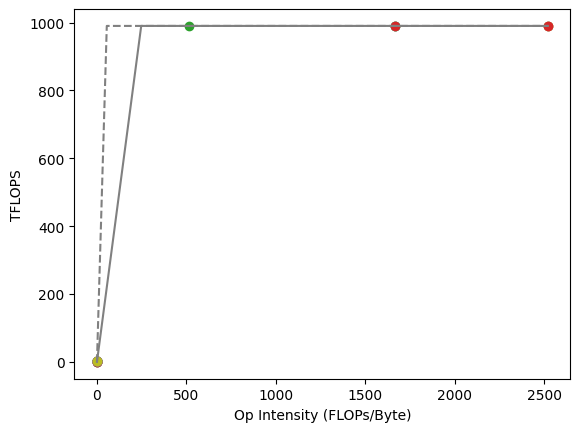

In [21]:
display_df(op_df)
dot_roofline(op_df, hopper_system, unit)


In [22]:
op_df.to_csv("gemma7B_on_hopper.csv")